<a href="https://www.kaggle.com/code/seherbal/heart-attack-eda-prediction?scriptVersionId=149880774" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
!pip install catboost

1. Age: Age of the patient
2. Sex: Sex of the patient
3. exang: exercise induced angina
*  - 1:yes
*  - 2: no
4. ca: number of major vessels(0-3)
5. cp: chest pain type 
*  - Value1: typical angina
*  - Value2: atypical angina
*  - Value3: non anginal pain 
*  - Value4: asyptomatic trtbps: resting blood pressure 
6. chol: cholestoral
7. fbs: fasting blood sugar >120
*    - 1: True
*    - 2: False
8. rest_ecg:resting resting electrocardiography
9. target: 
*      0. less chance of heart attack
*      1. more change of heart attack

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format',  '{:.2f}'.format)

In [4]:
df = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")

df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


**EDA**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
##################################
# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
##################################

##################################
# GENEL RESİM
##################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(303, 14)
##################### Types #####################
age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object
##################### Head #####################
   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  caa  thall  output
0   63    1   3     145   233    1        0       150     0     2.30    0    0      1       1
1   37    1   2     130   250    0        1       187     0     3.50    0    0      2       1
2   41    0   1     130   204    0        0       172     0     1.40    2    0      2       1
3   56    1   1     120   236    0        1       178     0     0.80    2    0      2       1
4   57    0   0     120   354    0        1       163     1     0.60    2    

303 gözlem birimi, 14 değişkenim var. Boş değer yok. 

In [7]:
df.duplicated().sum()
df.loc[df.duplicated(keep=False), :]
#yanlışlıkla mı oldu yoksa aynı şekilde veriler var mı ?

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
163,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.00,54.37,9.08,29.00,47.50,55.00,61.00,77.00
sex,303.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
cp,303.00,0.97,1.03,0.00,0.00,1.00,2.00,3.00
trtbps,303.00,131.62,17.54,94.00,120.00,130.00,140.00,200.00
chol,303.00,246.26,51.83,126.00,211.00,240.00,274.50,564.00
fbs,303.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
restecg,303.00,0.53,0.53,0.00,0.00,1.00,1.00,2.00
thalachh,303.00,149.65,22.91,71.00,133.50,153.00,166.00,202.00
exng,303.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00
oldpeak,303.00,1.04,1.16,0.00,0.00,0.80,1.60,6.20


**chol** değişkeni ortalaması 246 ve %50 si 240 birbirlerine oldukça yakınlar. %75 i 274 iken max değeri 564 neredeyse 2 katı. Burada outlier değer olabilir. 

In [9]:
#sınıf sayısı 10 un altında olanlara kategorik dedik.
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
num_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

****Visualization****

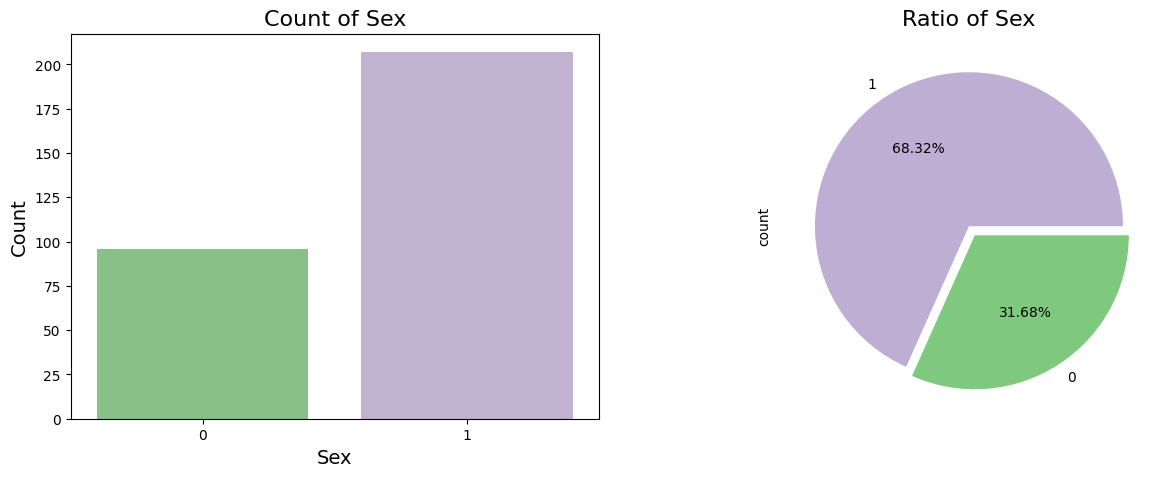

In [10]:
palette_color = sns.color_palette('Accent') 

fig, axs = plt.subplots(1,2, figsize = (15, 5))
ax = sns.countplot(data=df, 
                   x=df['sex'],
                   ax = axs[0], 
                   palette='Accent');

ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
axs[0].set_title("Count of Sex", fontsize=16)

ax2 = df['sex'].value_counts().plot.pie(explode=[0,0.07], 
                                             colors=[palette_color[1], palette_color[0]],
                                             ax = axs[1],
                                             autopct='%.2f%%');
axs[1].set_title("Ratio of Sex", fontsize=16);

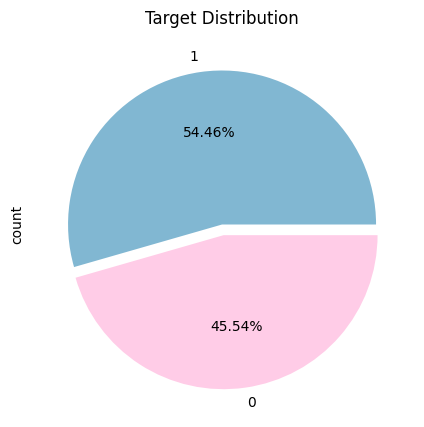

In [11]:
ax = df['output'].value_counts().plot.pie(explode=[0,0.07], 
                                               colors=["#81b7d2", "#ffcce7"],
                                               autopct='%.2f%%',
                                               figsize=(15, 5))
ax.set_title('Target Distribution');

veri setinin 54.46 sı atak geçirmiş, 45.54 ü geçirmemiş. 

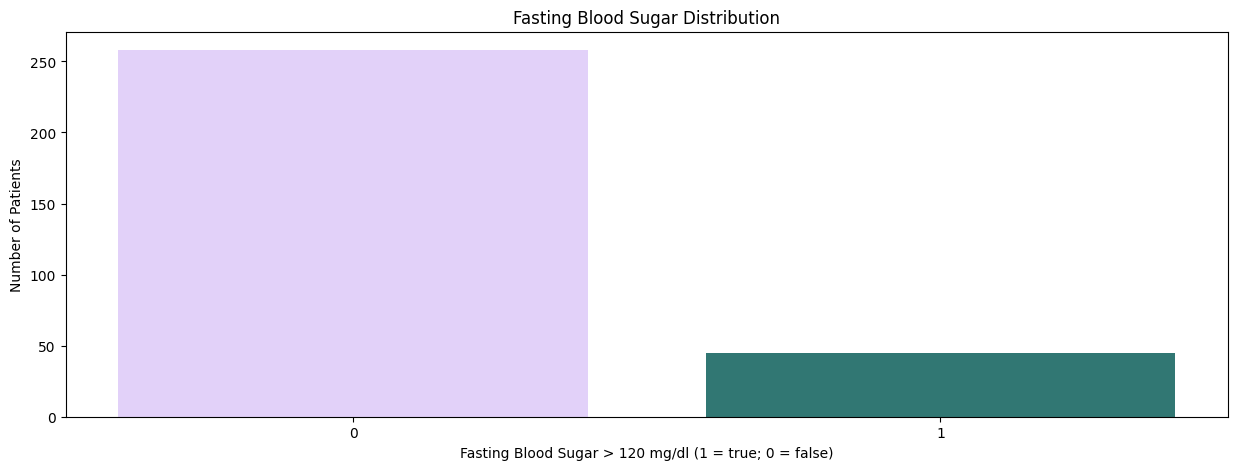

In [12]:
fbs_count = df['fbs'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(fbs_count.index, fbs_count.values, color=["#E2D1F9", "#317773"])
plt.title('Fasting Blood Sugar Distribution')
plt.xlabel('Fasting Blood Sugar > 120 mg/dl (1 = true; 0 = false)')
plt.ylabel('Number of Patients')
plt.xticks(fbs_count.index)
plt.show()

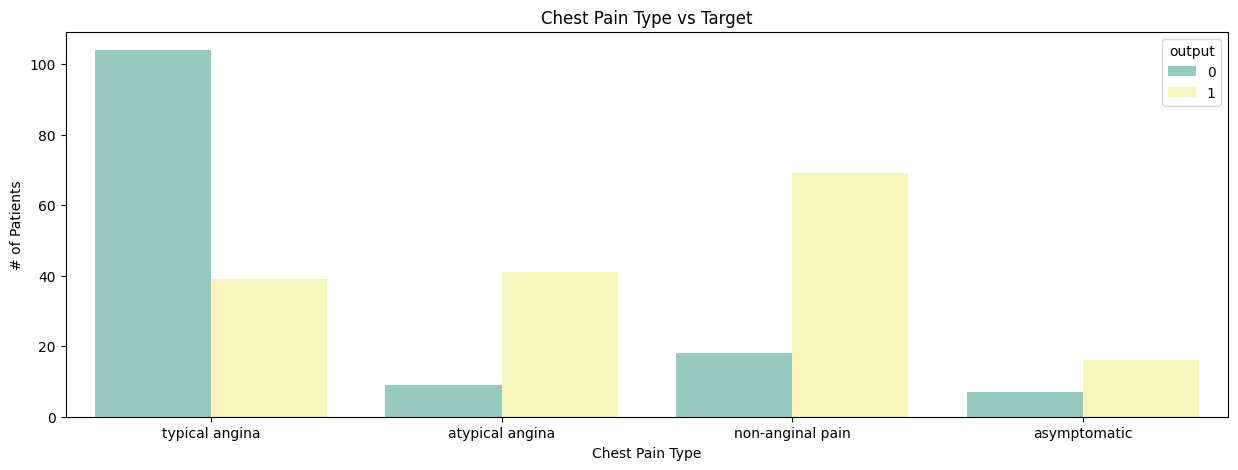

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, 
              x='cp', 
              hue='output', 
              palette="Set3")
plt.title('Chest Pain Type vs Target');
plt.xlabel('Chest Pain Type')
plt.ylabel('# of Patients')
plt.xticks(ticks=[0,1,2,3], 
           labels=['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'], rotation=0);

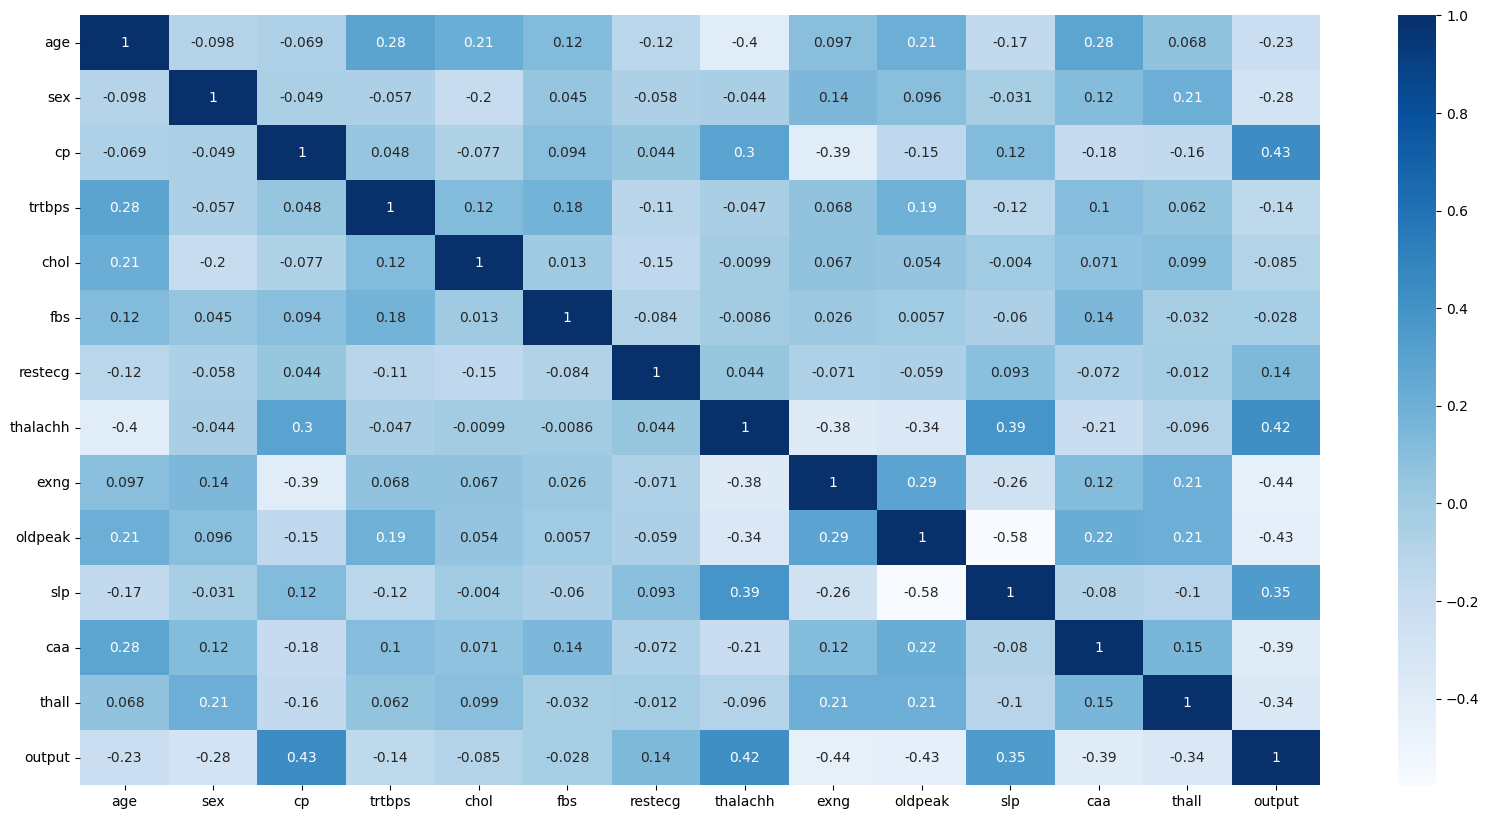

In [14]:
corr = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Blues", annot=True);

-60 veya +60 gibi değerler olsaydı o zzaman çıkarmak söz konusu olabilirdi. Yanlılığa sebep olmaması açısında böyle değerlendirebilriz. 

**Feature Engineering**

In [15]:
#missing values

print(pd.concat([df.isnull().sum(), df.isnull().sum()/len(df)*100],
                 keys=['Number of Missing Values', 'Ratio of Missing Values'],
                 axis=1))

          Number of Missing Values  Ratio of Missing Values
age                              0                     0.00
sex                              0                     0.00
cp                               0                     0.00
trtbps                           0                     0.00
chol                             0                     0.00
fbs                              0                     0.00
restecg                          0                     0.00
thalachh                         0                     0.00
exng                             0                     0.00
oldpeak                          0                     0.00
slp                              0                     0.00
caa                              0                     0.00
thall                            0                     0.00
output                           0                     0.00


In [16]:
#Outlier (baskılama)
def outlier_thresholds(df, col_name, low_quantile=0.25, up_quantile=0.75):
    Q1 = df[col_name].quantile(low_quantile)
    Q3 = df[col_name].quantile(up_quantile)
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    return low_limit, up_limit

In [17]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    

In [18]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
trtbps True
chol True
thalachh True
oldpeak True


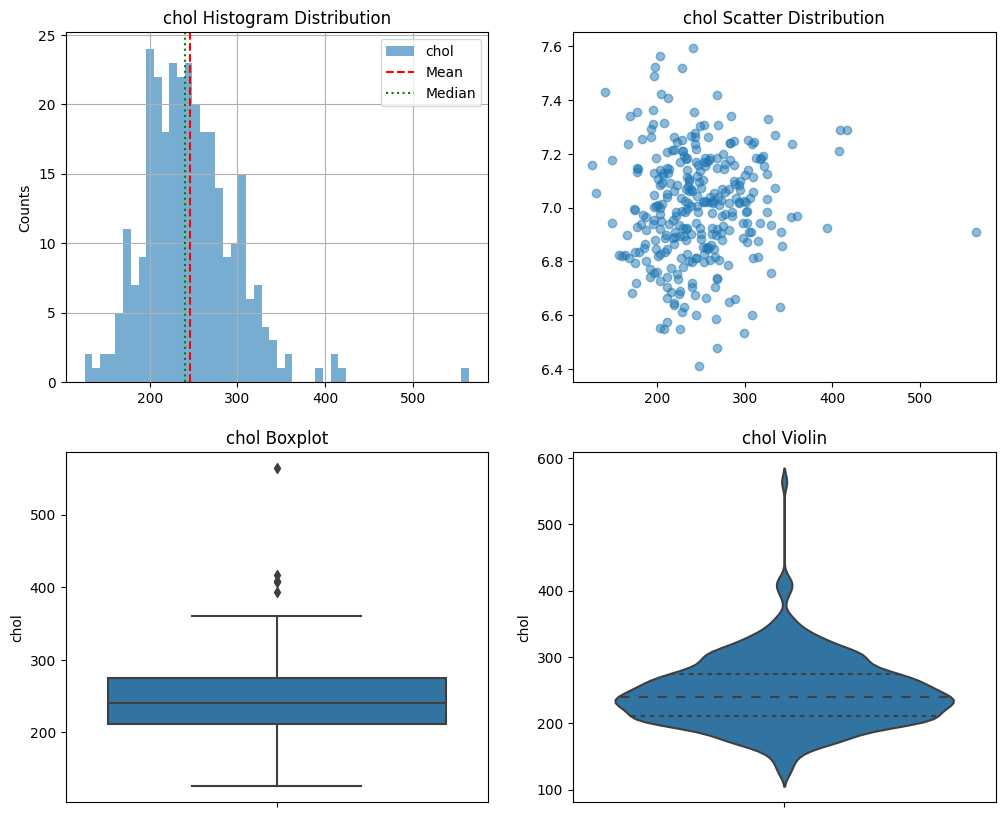

In [19]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df['chol'].hist(bins=50, label='chol', alpha=0.6)
plt.axvline(np.mean(df['chol']), ls='--', c='r', label="Mean")
plt.axvline(np.median(df['chol']), ls=':', c='g', label="Median")
plt.ylabel("Counts")
plt.title("chol Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df['chol'], np.random.normal(7, 0.2, size=df.shape[0]), alpha=0.5)
plt.title("chol Scatter Distribution");

plt.subplot(2, 2, 3)
sns.boxplot(y="chol", data=df)
plt.title("chol Boxplot");

plt.subplot(2, 2, 4)
sns.violinplot(y="chol", data=df, inner="quartile", bw=0.2)
plt.title("chol Violin");

In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
for col in num_cols:
    print(col, replace_with_thresholds(df, col))

age None
trtbps None
chol None
thalachh None
oldpeak None


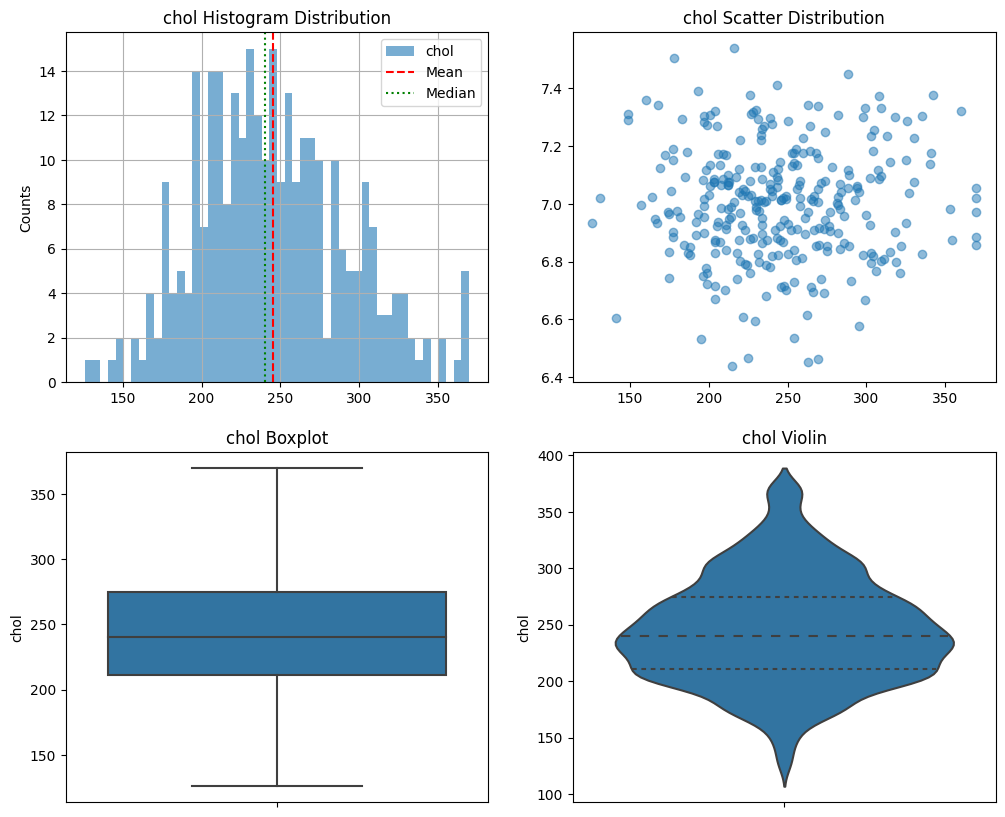

In [22]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df['chol'].hist(bins=50, label='chol', alpha=0.6)
plt.axvline(np.mean(df['chol']), ls='--', c='r', label="Mean")
plt.axvline(np.median(df['chol']), ls=':', c='g', label="Median")
plt.ylabel("Counts")
plt.title("chol Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df['chol'], np.random.normal(7, 0.2, size=df.shape[0]), alpha=0.5)
plt.title("chol Scatter Distribution");

plt.subplot(2, 2, 3)
sns.boxplot(y="chol", data=df)
plt.title("chol Boxplot");

plt.subplot(2, 2, 4)
sns.violinplot(y="chol", data=df, inner="quartile", bw=0.2)
plt.title("chol Violin");

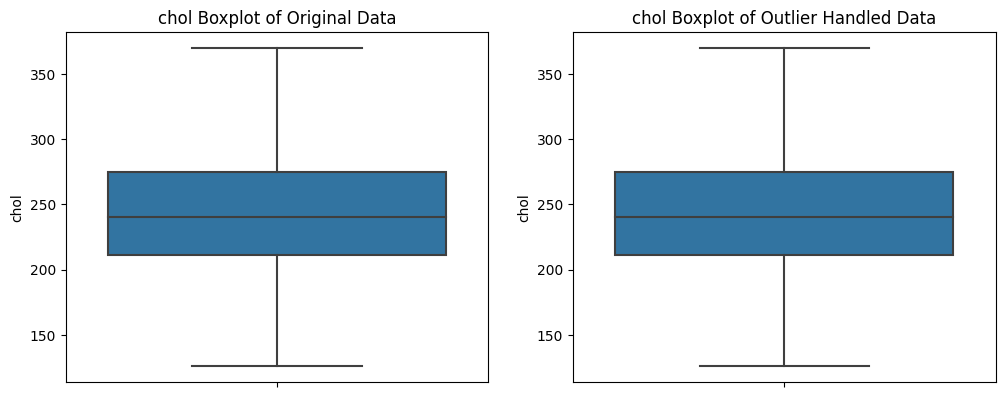

In [23]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y="chol", data=df)
plt.title("chol Boxplot of Original Data");

plt.subplot(2, 2, 2)
sns.boxplot(y="chol", data=df)
plt.title("chol Boxplot of Outlier Handled Data");

**Feature Extraction**

In [24]:
df['Age_CAT'] = pd.cut(x=df['age'], 
                            bins=[20, 40, 60, df['age'].max()], 
                            labels=["Adult", "Middle_Age_Adult", "Senior_Adult"])

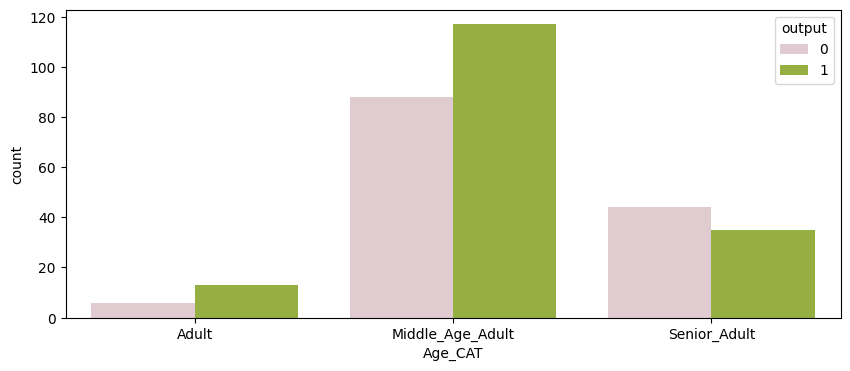

In [25]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Age_CAT', 
              hue='output', 
              order=["Adult", "Middle_Age_Adult", "Senior_Adult"],
              palette=["#E3C9CEFF", "#9FC131FF"])
plt.show()

In [26]:

cat_cols.append("Age_CAT")
cat_cols

['sex',
 'cp',
 'fbs',
 'restecg',
 'exng',
 'slp',
 'caa',
 'thall',
 'output',
 'Age_CAT']

In [27]:
def one_hot_encoder(dataframe, categorical_col, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_col, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 12 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
df = df.replace({True: 1, False: 0})

In [28]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [29]:
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output,cp_1,cp_2,cp_3,restecg_1,restecg_2,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3,Age_CAT_Middle_Age_Adult,Age_CAT_Senior_Adult
0,0.95,1,0.83,-0.26,1,0.01,0,1.15,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,-1.92,1,-0.08,0.10,0,1.64,0,2.23,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,-1.47,0,-0.08,-0.87,0,0.98,0,0.34,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,0.18,1,-0.68,-0.19,0,1.25,0,-0.20,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,0.29,0,-0.68,2.29,0,0.59,1,-0.38,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0


**Model Training**

In [30]:
y = df["output"]
X = df.drop("output", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
print('Shape of x_train is {}'.format(X_train.shape))
print('Shape of x_test is {}'.format(X_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (242, 24)
Shape of x_test is (61, 24)
Shape of y_train is (242,)
Shape of y_test is (61,)


In [32]:
models = [('LR', LogisticRegression(random_state=17, solver='lbfgs', max_iter=3000)),
          ('CART', DecisionTreeClassifier(random_state=17)),
          ('RF', RandomForestClassifier(random_state=17)),
          ('XGB', XGBClassifier(random_state=17, eval_metric='logloss')),
          ('LightGBM', LGBMClassifier(random_state=17, verbose=-1)),
          ('CatBoost', CatBoostClassifier(random_state=17, verbose=False))]

In [33]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
    print(f'########## {name} ##########')
    print(f'Accuracy: {round(cv_results["test_accuracy"].mean(), 4)}')
    print(f'Auc: {round(cv_results["test_roc_auc"].mean(), 4)}')
    print(f'Recall: {round(cv_results["test_recall"].mean(), 4)}')
    print(f'Precision: {round(cv_results["test_precision"].mean(), 4)}')
    print(f'F1: {round(cv_results["test_f1"].mean(), 4)}')

########## LR ##########
Accuracy: 0.858
Auc: 0.9218
Recall: 0.8901
Precision: 0.8594
F1: 0.8721
########## CART ##########
Accuracy: 0.7396
Auc: 0.7382
Recall: 0.7643
Precision: 0.766
F1: 0.7602
########## RF ##########
Accuracy: 0.7855
Auc: 0.8942
Recall: 0.8055
Precision: 0.8048
F1: 0.8024
########## XGB ##########
Accuracy: 0.7883
Auc: 0.8872
Recall: 0.8294
Precision: 0.7971
F1: 0.8088
########## LightGBM ##########
Accuracy: 0.8014
Auc: 0.8921
Recall: 0.8474
Precision: 0.8068
F1: 0.821
########## CatBoost ##########
Accuracy: 0.8147
Auc: 0.905
Recall: 0.8415
Precision: 0.8287
F1: 0.831
